In [2]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

## Question 1

### Part A

In [3]:
def generation(gmm_params,num=10000):
### gmm_params is a dictionary, its key are mu,Sigma,priors. It can represent a GMM distribution.
    np.random.seed(2023)
    priors = gmm_params['prior']
    C = len(priors)
    num_list = (num * priors).astype(int)
    mu = gmm_params['mu']
    cov = gmm_params['sigma']
    data = np.concatenate([np.random.multivariate_normal(mu[i],cov[i],size=val) for i,val in enumerate(num_list)])
    label = np.concatenate([i*np.ones(val) for i,val in enumerate(num_list)])
    return data,label

In [4]:
m0 = np.array([-1./2,-1./2,-1./2,-1./2])
c0 = 1./4*np.array([[2,-0.5,0.3,0],[-0.5,1,-0.5,0],[0.3,-0.5,1,0],[0,0,0,2]])
m1 = np.array([1,1,1,1])
c1 = np.array([[1,0.3,-0.2,0],[0.3,2,0.3,0],[-0.2,0.3,1,0],[0,0,0,3]])
m = np.array([[-1./2,-1./2,-1./2,-1./2],[1,1,1,1]])
c = np.array([c0,c1])

gmm_params = {}
gmm_params['mu'] = m
gmm_params['sigma'] = c
gmm_params['prior'] = np.array([0.35,0.65])
data,label = generation(gmm_params)

In [5]:
def ratioCal(data,label,gmm_params):
    mu = gmm_params['mu']
    sigma = gmm_params['sigma']
    prior = gmm_params['prior']
    ratio = []
    for i,item in enumerate(data):
        p1 = multivariate_normal.pdf(item,mu[1],sigma[1])
        p0 = multivariate_normal.pdf(item,m[0],sigma[0])
        ratio.append(p1/p0)
    return np.array(ratio)

def tpr_fpr_cal(label,ratio,val_list):
    tpr = []
    fpr = []
    for val in val_list:
        pred = np.zeros_like(label)
        pred[ratio>val] = 1
        tpr.append(np.logical_and(label==1,pred==1).sum()/(label==1).sum())
        fpr.append(np.logical_and(label==0,pred==1).sum()/(label==0).sum())
    tpr = np.array(tpr)
    fpr = np.array(fpr)
    return tpr,fpr

In [6]:
ratio = ratioCal(data,label,gmm_params)
val_list = np.sort(ratio)
tpr,fpr = tpr_fpr_cal(label,ratio,val_list)

In [7]:
prior = gmm_params['prior']
prob_err = fpr * prior[0] + (1 - tpr) * prior[1]
prob_err_min = min(prob_err)
threshold_exp = val_list[np.argmin(prob_err)]

optimal_gamma = prior[0]/prior[1]
pred = np.zeros_like(label)
pred[ratio>optimal_gamma] = 1
tpr_optimal = np.logical_and(label==1,pred==1).sum()/(label==1).sum()
fpr_optimal = np.logical_and(label==0,pred==1).sum()/(label==0).sum()
prob_err_opt = fpr_optimal * prior[0] + (1-tpr_optimal)*prior[1]

print(f'Empirically selected gamma {threshold_exp} minimizes P(error) which is {prob_err_min}!')
print(f'Theoretially optimal theoreshold is {optimal_gamma}, the probability of error is {prob_err_opt}')

Empirically selected gamma 0.44762079014733613 minimizes P(error) which is 0.02640000000000003!
Theoretially optimal theoreshold is 0.5384615384615384, the probability of error is 0.02659999999999997


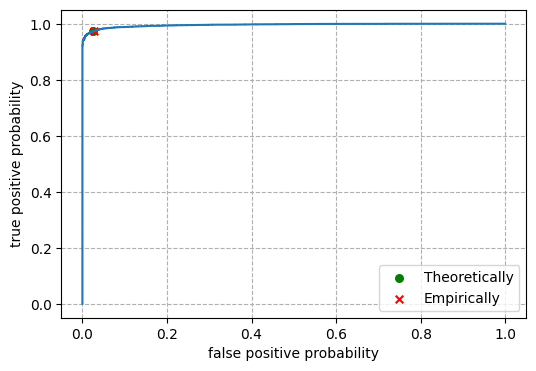

In [8]:
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr)
plt.scatter(fpr_optimal,tpr_optimal,marker='o',c='g',s=30,label='Theoretically')
plt.scatter(fpr[np.argmin(prob_err)],tpr[np.argmin(prob_err)],marker='x',c='r',s=30,label='Empirically')
plt.xlabel('false positive probability')
plt.ylabel('true positive probability')
plt.grid(linestyle='--')
plt.legend()
plt.show()

### Part B

In [9]:
m0 = np.array([-1./2,-1./2,-1./2,-1./2])
c0 = 1./4*np.array([[2,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,2]])
m1 = np.array([1,1,1,1])
c1 = np.array([[1,0,0,0],[0,2,0,0],[0,0,1,0],[0,0,0,3]])
m = np.array([[-1./2,-1./2,-1./2,-1./2],[1,1,1,1]])
c = np.array([c0,c1])

gmm_params = {}
gmm_params['mu'] = m
gmm_params['sigma'] = c
gmm_params['prior'] = np.array([0.35,0.65])

In [10]:
ratio_1 = ratioCal(data,label,gmm_params)
val_list_1 = np.sort(ratio_1)
tpr_1,fpr_1 = tpr_fpr_cal(label,ratio_1,val_list_1)

In [11]:
prob_err_1 = fpr_1 * prior[0] + (1 - tpr_1) * prior[1]
prob_err_min_1 = min(prob_err_1)
threshold_exp_1 = val_list_1[np.argmin(prob_err_1)]

print(f'Using incorrect knowledge, empirically selected gamma {threshold_exp_1} minimizes P(error) which is {prob_err_min_1}!')

Using incorrect knowledge, empirically selected gamma 0.5092261718997159 minimizes P(error) which is 0.032100000000000024!


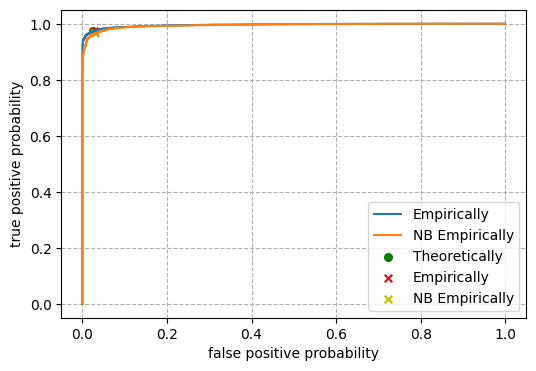

In [12]:
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr,label='Empirically')
plt.plot(fpr_1,tpr_1,label='NB Empirically')
plt.scatter(fpr_optimal,tpr_optimal,marker='o',c='g',s=30,label='Theoretically')
plt.scatter(fpr[np.argmin(prob_err)],tpr[np.argmin(prob_err)],marker='x',c='r',s=30,label='Empirically')
plt.scatter(fpr_1[np.argmin(prob_err_1)],tpr_1[np.argmin(prob_err_1)],marker='x',c='y',s=30,label='NB Empirically')

plt.xlabel('false positive probability')
plt.ylabel('true positive probability')
plt.grid(linestyle='--')
plt.legend()
plt.show()

### Part C

In [25]:
def lda(X,Y,C=2):
    mu = np.array([np.mean(X[Y==i],axis=0).reshape(-1,1) for i in range(C)])
    sigma = np.array([np.cov(X[Y==i].T) for i in range(C)])
    sb = (mu[1]-mu[0]).dot((mu[1]-mu[0]).T)
    sw = sigma[0] + sigma[1]
    eigval, eigvec = np.linalg.eig(np.linalg.inv(sw).dot(sb))
    idx = eigval.argsort()[::-1]
    eigvec = eigvec[:, idx]
    w = eigvec[:, 0]
    z = X@(w)
    return w, z

In [16]:
w,z = lda(X=data,Y=label)

In [26]:
w

array([0.59866206+0.j, 0.28086844+0.j, 0.71114533+0.j, 0.23872365+0.j])

In [17]:
val_list_2 = np.sort(z)
tpr_2,fpr_2 = tpr_fpr_cal(label,z,val_list_2)

In [24]:
prob_err_2 = fpr_2 * prior[0] + (1 - tpr_2) * prior[1]
prob_err_min_2 = min(prob_err_2)
threshold_exp_2 = val_list_2[np.argmin(prob_err_2)]
print(f'Using LDA, selected tao {threshold_exp_2} minimizes P(error) which is {prob_err_min_2}!')

Using LDA, selected tao (-0.04922788135126424+0j) minimizes P(error) which is 0.05169999999999997!


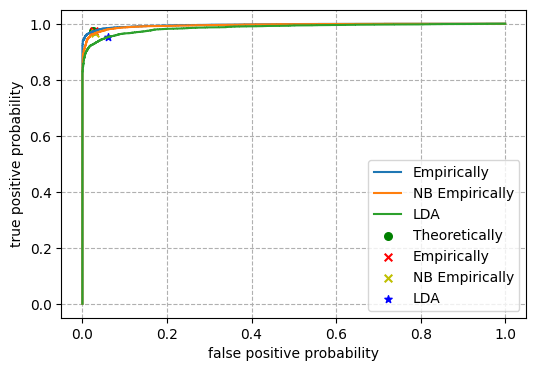

In [23]:
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr,label='Empirically')
plt.plot(fpr_1,tpr_1,label='NB Empirically')
plt.plot(fpr_2,tpr_2,label='LDA')
plt.scatter(fpr_optimal,tpr_optimal,marker='o',c='g',s=30,label='Theoretically')
plt.scatter(fpr[np.argmin(prob_err)],tpr[np.argmin(prob_err)],marker='x',c='r',s=30,label='Empirically')
plt.scatter(fpr_1[np.argmin(prob_err_1)],tpr_1[np.argmin(prob_err_1)],marker='x',c='y',s=30,label='NB Empirically')
plt.scatter(fpr_2[np.argmin(prob_err_2)],tpr_2[np.argmin(prob_err_2)],marker='*',c='b',s=30,label='LDA')

plt.xlabel('false positive probability')
plt.ylabel('true positive probability')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## Question 2

### Part A

In [63]:
def ERM(X, Lambda, gmm_params):
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['mu'][i], gmm_params['sigma'][i]) for i in range(len(gmm_params['prior']))])
    class_priors = np.diag(gmm_params['prior'])
    print(class_cond_likelihoods.shape,class_priors.shape)
    class_posteriors = class_priors.dot(class_cond_likelihoods)
    class_posteriors[-2,:] = class_posteriors[-2,:] + class_posteriors[-1,:]
    class_posteriors = class_posteriors[:-1,:]
    risk_mat = Lambda@class_posteriors
    return np.argmin(risk_mat, axis=0)

In [64]:
gmm_params = {}
gmm_params['mu'] = np.array([[0,0,0],[2,0,0],[0,2,0],[2,2,0]])
gmm_params['sigma'] = np.array([np.eye(3),np.eye(3),np.eye(3),np.eye(3)])
gmm_params['prior'] = np.array([0.3,0.3,0.2,0.2])
x,y = generation(gmm_params,num=10000)
y[y==3] = 2

(4, 10000) (4, 4)
The empirical estimated minimum probability error is 0.23809999999999998


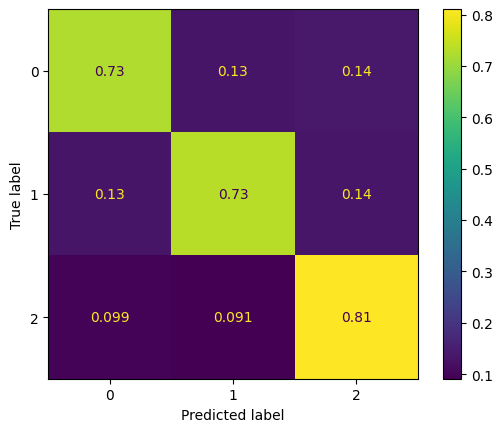

In [68]:
loss = np.ones((3,3)) - np.eye(3)
pred = ERM(x,loss,gmm_params)
cm = confusion_matrix(y,pred)
prob_err = 1 - np.diag(cm).sum()/cm.sum()
print(f'The empirical estimated minimum probability error is {prob_err}')
cm_prob = cm/cm.sum(axis=1,keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_prob,display_labels=[0,1,2])
disp.plot()
plt.show()

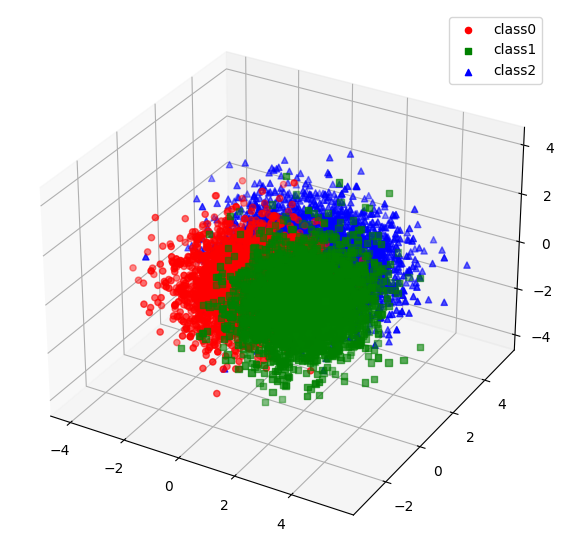

In [72]:
plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.scatter3D(x[y==0,0],x[y==0,1],x[y==0,2],c='r',marker='o',label='class0')
ax.scatter3D(x[y==1,0],x[y==1,1],x[y==1,2],c='g',marker='s',label='class1')
ax.scatter3D(x[y==2,0],x[y==2,1],x[y==2,2],c='b',marker='^',label='class2')
plt.legend()
plt.show()

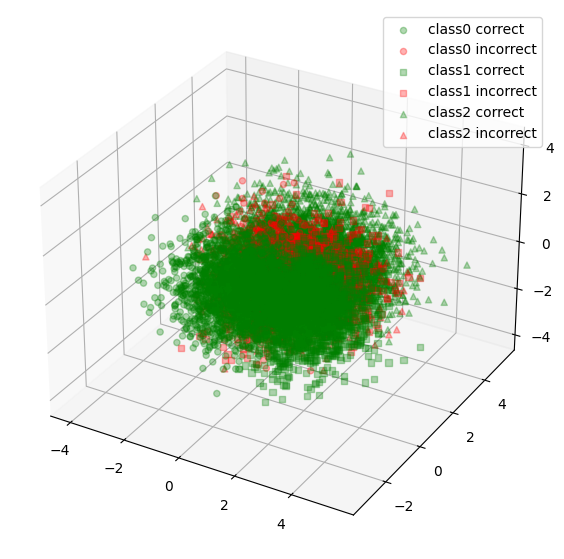

In [82]:
plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

marker = ['o','s','^']

for i in range(3):
    idx = np.logical_and(y==i,pred==i)
    idx1 = np.logical_and(y==i,pred!=i)
    ax.scatter3D(x[idx,0],x[idx,1],x[idx,2],c='g',marker=marker[i],alpha=0.3,label=f'class{i} correct')
    ax.scatter3D(x[idx1,0],x[idx1,1],x[idx1,2],c='r',marker=marker[i],alpha=0.3,label=f'class{i} incorrect')
plt.legend()
plt.show()

### Part B

(4, 10000) (4, 4)
The empirical estimated minimum probability error is 0.3587


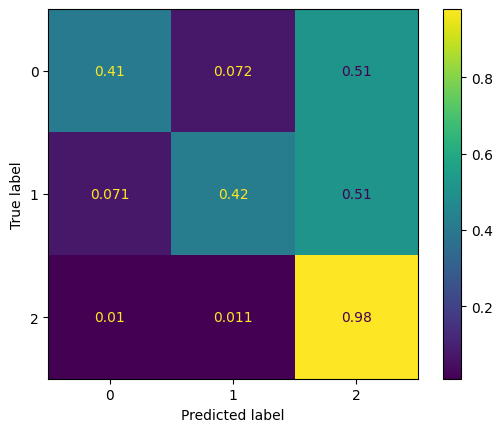

In [83]:
Lambda10 = np.array([[0,1,10],[1,0,10],[1,1,0]])
Lambda100 = np.array([[0,1,100],[1,0,100],[1,1,0]])
pred_10 = ERM(x,Lambda=Lambda10,gmm_params=gmm_params)
cm = confusion_matrix(y,pred_10,labels=[0,1,2])
prob_err = 1 - np.diag(cm).sum()/cm.sum()
print(f'The empirical estimated minimum probability error is {prob_err}')
cm_prob = cm/cm.sum(axis=1,keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_prob,display_labels=[0,1,2])
disp.plot()
plt.show()

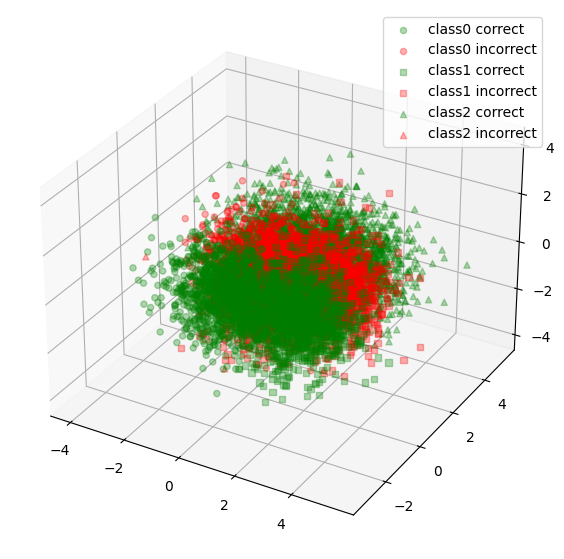

In [84]:
plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

marker = ['o','s','^']

for i in range(3):
    idx = np.logical_and(y==i,pred_10==i)
    idx1 = np.logical_and(y==i,pred_10!=i)
    ax.scatter3D(x[idx,0],x[idx,1],x[idx,2],c='g',marker=marker[i],alpha=0.3,label=f'class{i} correct')
    ax.scatter3D(x[idx1,0],x[idx1,1],x[idx1,2],c='r',marker=marker[i],alpha=0.3,label=f'class{i} incorrect')
plt.legend()
plt.show()

(4, 10000) (4, 4)
The empirical estimated minimum probability error is 0.5382


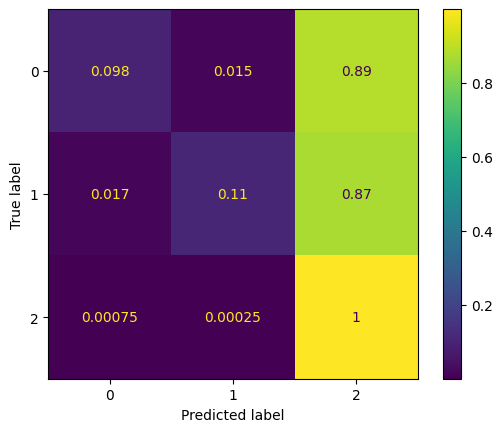

In [87]:
pred_100 = ERM(x,Lambda=Lambda100,gmm_params=gmm_params)
cm = confusion_matrix(y,pred_100,labels=[0,1,2])
prob_err = 1 - np.diag(cm).sum()/cm.sum()
print(f'The empirical estimated minimum probability error is {prob_err}')
cm_prob = cm/cm.sum(axis=1,keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_prob,display_labels=[0,1,2])
disp.plot()
plt.show()

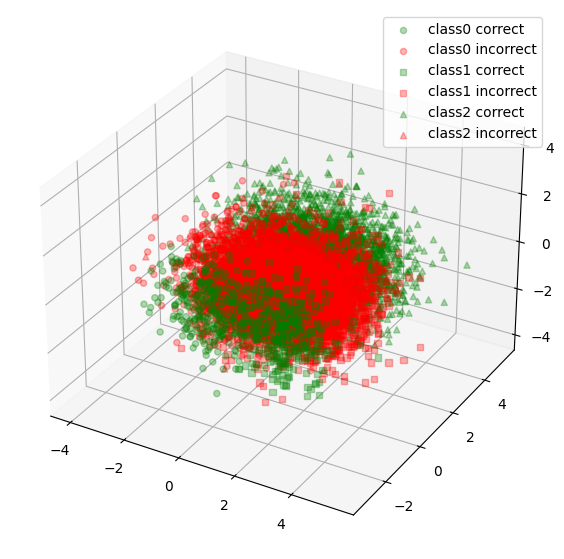

In [88]:
plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

marker = ['o','s','^']

for i in range(3):
    idx = np.logical_and(y==i,pred_100==i)
    idx1 = np.logical_and(y==i,pred_100!=i)
    ax.scatter3D(x[idx,0],x[idx,1],x[idx,2],c='g',marker=marker[i],alpha=0.3,label=f'class{i} correct')
    ax.scatter3D(x[idx1,0],x[idx1,1],x[idx1,2],c='r',marker=marker[i],alpha=0.3,label=f'class{i} incorrect')
plt.legend()
plt.show()

## Question 3

In [102]:
def erm_classification(X, Lambda, gmm_params, C):    
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['mu'][i], gmm_params['sigma'][i]) for i in range(C)])
    class_priors = np.diag(gmm_params['prior'])
    class_posteriors = class_priors.dot(class_cond_likelihoods)
    risk_mat = Lambda@class_posteriors
    return np.argmin(risk_mat, axis=0)

def regCov(X,lam):
    cov = np.cov(X)
    return cov + lam*np.eye(len(X))

In [103]:
wine = pd.read_csv('winequality-white.csv',delimiter=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [104]:
x = wine.drop(columns='quality',axis=1)
y_original = wine['quality']
y_original.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [105]:
le = LabelEncoder()
le.fit(y_original)
y = le.transform(y_original)

In [106]:
C = len(np.unique(y))
gmm_params = {}
gmm_params['prior'] = np.array([(y==i).sum() for i in np.unique(y)])/len(y)
gmm_params['mu'] = np.array([x[y==i].mean(axis=0) for i in np.unique(y)])
gmm_params['sigma'] = np.array([regCov(x[y==i].T,lam=0.1) for i in np.unique(y)])
Lambda = np.ones((C,C)) - np.eye(C)
pred = erm_classification(X=x,Lambda=Lambda,gmm_params=gmm_params,C=C)

<Figure size 1200x1200 with 0 Axes>

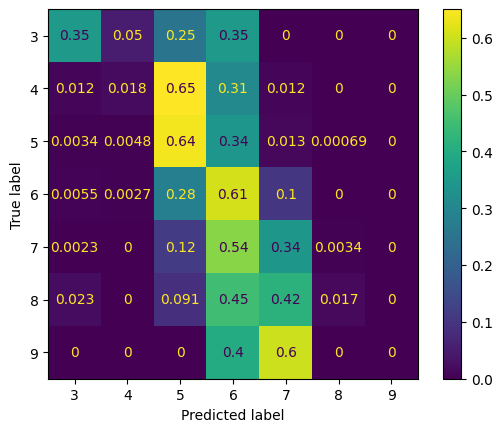

In [123]:
cm = confusion_matrix(y,pred)
cm_prob = cm/cm.sum(axis=1,keepdims=True)
plt.figure(figsize=(12,12))
disp = ConfusionMatrixDisplay(cm_prob,display_labels=np.unique(y))
disp.plot()
plt.xticks(np.unique(y),le.inverse_transform(np.unique(y)))
plt.yticks(np.unique(y),le.inverse_transform(np.unique(y)))

plt.show()

In [124]:
prob_err = 1 - np.diag(cm).sum()/len(x)
print(f'The empirical estimated minimum probability error is {prob_err}')

The empirical estimated minimum probability error is 0.4726418946508779


In [125]:
pca = PCA(n_components=3)
x_trans = pca.fit_transform(x)
var_ratio = pca.explained_variance_ratio_
var_ratio

array([0.90965734, 0.07933386, 0.01015427])

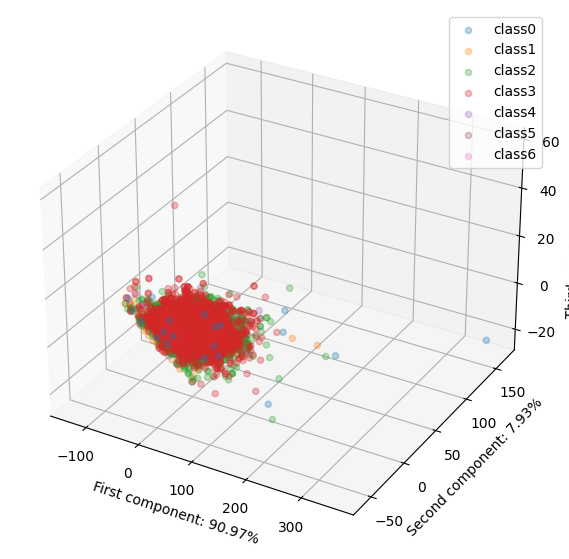

In [126]:
plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
for i in np.unique(y):
    ax.scatter3D(x_trans[y==i,0],x_trans[y==i,1],x_trans[y==i,2],alpha=0.3,label=f'class{i}')
ax.set_xlabel(f'First component: {np.round(100*var_ratio[0],2)}%')
ax.set_ylabel(f'Second component: {np.round(100*var_ratio[1],2)}%')
ax.set_zlabel(f'Third component: {np.round(100*var_ratio[2],2)}%')

plt.legend()
plt.show()

In [127]:
x_har_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt',delim_whitespace=True,header=None)
x_har_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt',delim_whitespace=True,header=None)
y_har_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt',delim_whitespace=True,header=None)
y_har_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt',delim_whitespace=True,header=None)
x = pd.concat([x_har_train,x_har_test])
y_original = pd.concat([y_har_train,y_har_test])
print(x.shape)
print(y.shape)

(10299, 561)
(4898,)


In [129]:
le = LabelEncoder()
le.fit(y_original.values.flatten())
y = le.transform(y_original.values.flatten())

In [131]:
C = len(np.unique(y))
gmm_params = {}
gmm_params['prior'] = np.array([(y==i).sum() for i in np.unique(y)])/len(y)
gmm_params['mu'] = np.array([x[y==i].mean(axis=0) for i in np.unique(y)])
gmm_params['sigma'] = np.array([regCov(x[y==i].T,lam=0.1) for i in np.unique(y)])
Lambda = np.ones((C,C)) - np.eye(C)
pred = erm_classification(X=x,Lambda=Lambda,gmm_params=gmm_params,C=C)

<Figure size 1200x1200 with 0 Axes>

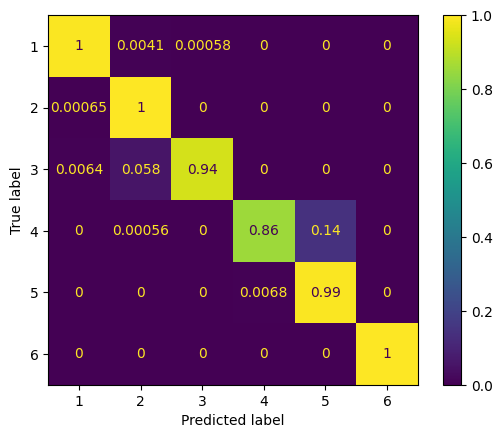

In [132]:
cm = confusion_matrix(y,pred)
cm_prob = cm/cm.sum(axis=1,keepdims=True)
plt.figure(figsize=(12,12))
disp = ConfusionMatrixDisplay(cm_prob,display_labels=np.unique(y))
disp.plot()
plt.xticks(np.unique(y),le.inverse_transform(np.unique(y)))
plt.yticks(np.unique(y),le.inverse_transform(np.unique(y)))

plt.show()

In [137]:
prob_err = 1 - np.diag(cm).sum()/len(x)
print(f'The empirical estimated minimum probability error is {prob_err}')

The empirical estimated minimum probability error is 0.03592581804058648


In [134]:
pca = PCA(n_components=3)
x_trans = pca.fit_transform(x)
var_ratio = pca.explained_variance_ratio_
var_ratio

array([0.62227069, 0.04772595, 0.04018191])

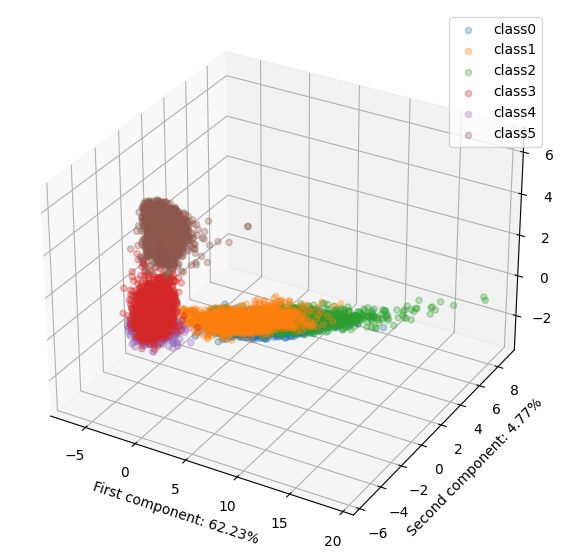

In [135]:
plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
for i in np.unique(y):
    ax.scatter3D(x_trans[y==i,0],x_trans[y==i,1],x_trans[y==i,2],alpha=0.3,label=f'class{i}')
ax.set_xlabel(f'First component: {np.round(100*var_ratio[0],2)}%')
ax.set_ylabel(f'Second component: {np.round(100*var_ratio[1],2)}%')
ax.set_zlabel(f'Third component: {np.round(100*var_ratio[2],2)}%')

plt.legend()
plt.show()